# Frenet on Carla

In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

In [2]:
from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
from util.geometry_util import dist_point_linestring

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import random
import cv2
from pathlib import Path
import numpy as np
import pygame
import math
import weakref
import pickle
import copy
from typing import List

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
# from util.geometry_util import dist_point_linestring


In [4]:
from quintic_polynomials_planner import QuinticPolynomial
import cubic_spline_planner

In [5]:

from frenet_optimal_trajectory import FrenetPlanner as MotionPlanner

import imageio
from copy import deepcopy

In [6]:
optimalDistance = 8
followDrivenPath = True
evaluateChasingCar = True
record = False
chaseMode = True
followMode = False

drivesDir = './drives'
drivesFileNames = os.listdir(drivesDir)
drivesFileNames.sort()

drivesFileNames = ['ride5.p']  #   ['ride8.p']  ['ride10.p']  for testing advance angle turns # turnel ['ride15.p']  


In [7]:
def send_control(vehicle, throttle, steer, brake,
                 hand_brake=False, reverse=False):
    throttle = np.clip(throttle, 0.0, 1.0)
    steer = np.clip(steer, -1.0, 1.0)
    brake = np.clip(brake, 0.0, 1.0)
    control = carla.VehicleControl(throttle, steer, brake, hand_brake, reverse)
    vehicle.apply_control(control)


def get_speed(vehicle):
    """
    Compute speed of a vehicle in Kmh
    :param vehicle: the vehicle for which speed is calculated
    :return: speed as a float in Kmh
    """
    vel = vehicle.get_velocity()
    # return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # 3.6 * meter per seconds = kmh
    return math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # meter per seconds



In [8]:

# New Classes
class Evaluation():
    def __init__(self):
        self.sumMAE = 0
        self.sumRMSE = 0
        self.n_of_frames = 0
        self.n_of_collisions = 0
        self.history = []

    def AddError(self, distance, goalDistance):
        self.n_of_frames += 1
        self.sumMAE += abs(goalDistance-distance)
        self.sumRMSE += abs(goalDistance-distance)*abs(goalDistance-distance)

    def WriteIntoFileFinal(self, filename, driveName):
        if self.n_of_frames > 0:
            self.sumMAE = self.sumMAE / float(self.n_of_frames)
            self.sumRMSE = self.sumRMSE / float(self.n_of_frames)

        with open(filename,'a') as f:
            f.write(str(driveName)+', '+str(self.sumMAE)+', '+str(self.sumRMSE)+', '+str(self.n_of_collisions)+'\n')

    def LoadHistoryFromFile(self, fileName):
        self.history = pickle.load( open(fileName, "rb"))

    def CollisionHandler(self,event):
        self.n_of_collisions += 1


class LineOfSightSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self.distance = None
        self.vehicle_ahead = None
        self._parent = parent_actor
        # self.sensor_transform = carla.Transform(carla.Location(x=4, z=1.7), carla.Rotation(yaw=0)) # Put this sensor on the windshield of the car.
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.obstacle')
        bp.set_attribute('distance', '200')
        bp.set_attribute('hit_radius', '0.5')
        bp.set_attribute('only_dynamics', 'True')
        bp.set_attribute('debug_linetrace', 'True')
        bp.set_attribute('sensor_tick', '0.0')
        self.sensor = world.spawn_actor(bp, carla.Transform(), attach_to=self._parent)
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: LineOfSightSensor._on_los(weak_self, event))

    def reset(self):
        self.vehicle_ahead = None
        self.distance = None

    def destroy(self):
        self.sensor.destroy()

    def get_vehicle_ahead(self):
        return self.vehicle_ahead

    # Only works for CARLA 9.6 and above!
    def get_los_distance(self):
        return self.distance

    @staticmethod
    def _on_los(weak_self, event):
        self = weak_self()
        if not self:
            return
        self.vehicle_ahead = event.other_actor
        self.distance = event.distance



In [9]:
class QuarticPolynomial:

    def __init__(self, xs, vxs, axs, vxe, axe, time):
        # calc coefficient of quartic polynomial

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[3 * time ** 2, 4 * time ** 3],
                      [6 * time, 12 * time ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * time,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t ** 2 + \
             self.a3 * t ** 3 + self.a4 * t ** 4

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
             3 * self.a3 * t ** 2 + 4 * self.a4 * t ** 3

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t ** 2

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t

        return xt

In [10]:
def calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0):
    frenet_paths = []

    # generate path to each offset goal
    for di in np.arange(-MAX_ROAD_WIDTH, MAX_ROAD_WIDTH, D_ROAD_W):

        # Lateral motion planning
        for Ti in np.arange(MIN_T, MAX_T, DT):
            fp = FrenetPath()

            lat_qp = QuinticPolynomial(c_d, c_d_d, c_d_dd, di, 0.0, 0.0, Ti)

            fp.t = [t for t in np.arange(0.0, Ti, DT)]
            fp.d = [lat_qp.calc_point(t) for t in fp.t]
            fp.d_d = [lat_qp.calc_first_derivative(t) for t in fp.t]
            fp.d_dd = [lat_qp.calc_second_derivative(t) for t in fp.t]
            fp.d_ddd = [lat_qp.calc_third_derivative(t) for t in fp.t]

            # Longitudinal motion planning (Velocity keeping)
            for tv in np.arange(TARGET_SPEED - D_T_S * N_S_SAMPLE,
                                TARGET_SPEED + D_T_S * N_S_SAMPLE, D_T_S):
                tfp = copy.deepcopy(fp)
                lon_qp = QuarticPolynomial(s0, c_speed, 0.0, tv, 0.0, Ti)

                tfp.s = [lon_qp.calc_point(t) for t in fp.t]
                tfp.s_d = [lon_qp.calc_first_derivative(t) for t in fp.t]
                tfp.s_dd = [lon_qp.calc_second_derivative(t) for t in fp.t]
                tfp.s_ddd = [lon_qp.calc_third_derivative(t) for t in fp.t]

                Jp = sum(np.power(tfp.d_ddd, 2))  # square of jerk
                Js = sum(np.power(tfp.s_ddd, 2))  # square of jerk

                # square of diff from target speed
                ds = (TARGET_SPEED - tfp.s_d[-1]) ** 2

                tfp.cd = K_J * Jp + K_T * Ti + K_D * tfp.d[-1] ** 2
                tfp.cv = K_J * Js + K_T * Ti + K_D * ds
                tfp.cf = K_LAT * tfp.cd + K_LON * tfp.cv

                frenet_paths.append(tfp)

    return frenet_paths






In [11]:
def check_paths(fplist, ob):
    ok_ind = []
    for i, _ in enumerate(fplist):
        if any([v > MAX_SPEED for v in fplist[i].s_d]):  # Max speed check
            continue
        elif any([abs(a) > MAX_ACCEL for a in
                  fplist[i].s_dd]):  # Max accel check
            continue
        elif any([abs(c) > MAX_CURVATURE for c in
                  fplist[i].c]):  # Max curvature check
            continue
        elif not check_collision(fplist[i], ob):
            continue

        ok_ind.append(i)

    return [fplist[i] for i in ok_ind]

In [12]:
def check_collision(fp, ob):
    for i in range(len(ob[:, 0])):
        d = [((ix - ob[i, 0]) ** 2 + (iy - ob[i, 1]) ** 2)
             for (ix, iy) in zip(fp.x, fp.y)]

        collision = any([di <= ROBOT_RADIUS ** 2 for di in d])

        if collision:
            return False

    return True


In [13]:
# Frenet imports

from cubic_spline_planner import *

def generate_target_course(x, y, z):
    csp = Spline3D(x, y, z)
    s = np.arange(0, csp.s[-1], 0.1)

    rx, ry, rz, ryaw, rk = [], [], [], [], []
    for i_s in s:
        ix, iy, iz = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        rz.append(iz)
        ryaw.append(csp.calc_yaw(i_s))
        rk.append(csp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, csp

In [14]:
def frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob):
    fplist = calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0)
    fplist = calc_global_paths(fplist, csp)
    fplist = check_paths(fplist, ob)

    # find minimum cost path
    min_cost = float("inf")
    best_path = None
    for fp in fplist:
        if min_cost >= fp.cf:
            min_cost = fp.cf
            best_path = fp

    return best_path

In [15]:

def frenet_to_inertial(s, d, csp):
    """
    transform a point from frenet frame to inertial frame
    input: frenet s and d variable and the instance of global cubic spline class
    output: x and y in global frame
    """
    ix, iy, iz = csp.calc_position(s)
    iyaw = csp.calc_yaw(s)
    x = ix + d * math.cos(iyaw + math.pi / 2.0)
    y = iy + d * math.sin(iyaw + math.pi / 2.0)

    return x, y, iz, iyaw

In [16]:
class FrenetPath:

    def __init__(self):
        self.t = []
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        self.cd = 0.0
        self.cv = 0.0
        self.cf = 0.0

        self.x = []
        self.y = []
        self.z = []
        self.yaw = []
        self.ds = []
        self.c = []

        self.v = []  # speed

In [17]:
SIM_LOOP = 500

# Parameter
MAX_SPEED = 30.0 / 3.6  # maximum speed [m/s]
MAX_ACCEL = 2.0  # maximum acceleration [m/ss]
MAX_CURVATURE = 1.0  # maximum curvature [1/m]
MAX_ROAD_WIDTH = 7.0  # maximum road width [m]
D_ROAD_W = 1.0  # road width sampling length [m]
DT = 0.2  # time tick [s]
MAX_T = 5.0  # max prediction time [m]
MIN_T = 4.0  # min prediction time [m]
TARGET_SPEED = 20.0 / 3.6  # target speed [m/s]
D_T_S = 5.0 / 3.6  # target speed sampling length [m/s]
N_S_SAMPLE = 1  # sampling number of target speed
ROBOT_RADIUS = 2.0  # robot radius [m]

# cost weights
K_J = 0.1
K_T = 0.1
K_D = 1.0
K_LAT = 1.0
K_LON = 1.0


show_animation = True

In [18]:
from IPython import display as ipython_display
import pylab as pl

In [34]:
def main(optimalDistance, followDrivenPath, chaseMode, evaluateChasingCar, driveName='',record=False, followMode=False,
         resultsName='results',P=None,I=None,D=None,nOfFramesToSkip=0):
    # Imports
    # from cores.lane_detection.lane_detector import LaneDetector
    # from cores.lane_detection.camera_geometry import CameraGeometry
    # from cores.control.pure_pursuit import PurePursuitPlusPID

    # New imports
    from DrivingControl import DrivingControl
    from DrivingControlAdvanced import DrivingControlAdvanced
    from CarDetector import CarDetector
    from SemanticSegmentation import SemanticSegmentation


    # New Variables
    extrapolate = True
    optimalDistance = 2
    followDrivenPath = True
    evaluateChasingCar = True
    record = False
    chaseMode = True
    followMode = False
    counter = 1
    sensors = []

    vehicleToFollowSpawned = False
    obsticle_vehicleSpawned = False

    # New objects
    carDetector = CarDetector()
    drivingControl = DrivingControl(optimalDistance=optimalDistance)
    drivingControlAdvanced = DrivingControlAdvanced(optimalDistance=optimalDistance)
    evaluation = Evaluation()
    semantic = SemanticSegmentation()


    actor_list = []
    pygame.init()

#     display = pygame.display.set_mode(
#         (800, 600),
#         pygame.HWSURFACE | pygame.DOUBLEBUF)
    font = get_font()
    clock = pygame.time.Clock()

    client = carla.Client('localhost', 2000)
    client.set_timeout(80.0)

    #client.load_world('Town06')
    # client.load_world('Town04')
    world = client.get_world()
    weather_presets = find_weather_presets()
    # print(weather_presets)
    world.set_weather(weather_presets[3][0])
    # world.set_weather(carla.WeatherParameters.HardRainSunset)

    # controller = PurePursuitPlusPID()

#     # Set BirdView
#     birdview_producer = BirdViewProducer(
#         client,
#         PixelDimensions(width=DEFAULT_WIDTH, height=DEFAULT_HEIGHT),
#         pixels_per_meter=4,
#         crop_type=BirdViewCropType.FRONT_AND_REAR_AREA,
#         render_lanes_on_junctions=False,
#     )


    try:
        m = world.get_map()

        blueprint_library = world.get_blueprint_library()

        veh_bp = random.choice(blueprint_library.filter('vehicle.dodge_charger.police'))
        vehicle = world.spawn_actor(
            veh_bp,
            m.get_spawn_points()[90])
        actor_list.append(vehicle)

        # New vehicle property
        vehicle.set_simulate_physics(True)

        if followDrivenPath:
            evaluation.LoadHistoryFromFile(driveName)
            first = evaluation.history[0]
            start_pose = carla.Transform(carla.Location(first[0], first[1], first[2]),
                                        carla.Rotation(first[3], first[4], first[5]))
            vehicle.set_transform(start_pose)

        # New Sensors
        collision_sensor = world.spawn_actor(blueprint_library.find('sensor.other.collision'),
                                                carla.Transform(), attach_to=vehicle)
        collision_sensor.listen(lambda event: evaluation.CollisionHandler(event))
        actor_list.append(collision_sensor)

        
        # front cam for object detection
        camera_rgb_blueprint = world.get_blueprint_library().find('sensor.camera.rgb')
        camera_rgb_blueprint.set_attribute('fov', '90')
        camera_rgb = world.spawn_actor(
           camera_rgb_blueprint,
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0.3), carla.Rotation(pitch=0)),
            attach_to=vehicle)
        actor_list.append(camera_rgb)
        sensors.append(camera_rgb)

            
        # segmentation camera
        camera_segmentation = world.spawn_actor(
            blueprint_library.find('sensor.camera.semantic_segmentation'),
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0), carla.Rotation(pitch=0)), #5,3,0 # -0.3
            attach_to=vehicle)
        actor_list.append(camera_segmentation)
        sensors.append(camera_segmentation)


        
        # Set up local planner and behavnioural planner
        # --------------------------------------------------------------

        print("vehicle.get_transform():", vehicle.get_transform())
        

        # Start Modules
   

        # --------------------------------------------------------------


        frame = 0
        max_error = 0
        FPS = 30
        speed = 0
        cross_track_error = 0
        start_time = 0.0
        times = 8
        LP_FREQUENCY_DIVISOR   = 8                # Frequency divisor to make the 
                                                # local planner operate at a lower
                                                # frequency than the controller
                                                # (which operates at the simulation
                                                # frequency). Must be a natural
                                                # number.
                            


        actors_batch = []
        
        print("Len of waypoints:" , len(evaluation.history))
        
        
                
        # TMP obstacle lists
        ob = np.array([[233.980630, 130.523910],
                       [233.980630, 30.523910],
                       [233.980630, 60.523910],
                       [233.980630, 80.523910],
                       [233.786942, 75.530586],
                       ])
        
        
        def look_ahead_local_planer(waypoints: List, current_idx: int=0, look_ahead: int=20 ):
            
            wx = []
            wy = []
            wz = []

            for p in waypoints[current_idx: (current_idx + look_ahead)]:
                wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
                wx.append(wp.location.x)
                wy.append(wp.location.y)
                wz.append(wp.location.z)

#             print("wx: ", wx)
            tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)
            
            return csp
        
        
                    
        wx = []
        wy = []
        wz = []

        for p in evaluation.history:
            wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
            wx.append(wp.location.x)
            wy.append(wp.location.y)
            wz.append(wp.location.z)


        tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)


                
        # initial state
        c_speed = 10.0 / 3.6  # current speed [m/s]
        c_d = 2.0  # current lateral position [m]
        c_d_d = 0.0  # current lateral speed [m/s]
        c_d_dd = 0.0  # current latral acceleration [m/s]
        s0 = 0.0  # current course position    
        
        trail_c_speed = 10.0 / 3.6  # current speed [m/s]
        trail_c_d = 2.0  # current lateral position [m]
        trail_c_d_d = 0.0  # current lateral speed [m/s]
        trail_c_d_dd = 0.0  # current latral acceleration [m/s]
        trail_s0 = 0.0  # current course position    
        
        
        area = 40.0  # animation area length [m]

        fig = plt.figure()
        
        
        # Leading waypoints 
        leading_waypoints = []
     
        
        i = 0
        
        # Create a synchronous mode context.
        with CarlaSyncMode(world, *sensors, fps=FPS) as sync_mode:
            while i <100:
                if should_quit():
                    return
        
                # snapshot, image_rgb, image_segmentation = tick_response
                snapshot, img_rgb, image_segmentation = sync_mode.tick(timeout=2.0)

                # detect car in image with semantic segnmentation camera
                carInTheImage = semantic.IsThereACarInThePicture(image_segmentation)

                line = []

                # ------------------- Set up leading vehicle --------------------------------
                # Spawn a vehicle to follow
                if not vehicleToFollowSpawned and followDrivenPath:
                    vehicleToFollowSpawned = True
                    location1 = vehicle.get_transform()
                    newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,
                                                                     location1.rotation.yaw)
                    diffX = newX - location1.location.x
                    diffY = newY - location1.location.y
                    newX = location1.location.x - (diffX*5)
                    newY = location1.location.y - (diffY*5)

                    start_pose.location.x = newX
                    start_pose.location.y = newY

                    vehicle.set_transform(start_pose)

                    start_pose2 = random.choice(m.get_spawn_points())

                    bp = blueprint_library.filter('model3')[0]
                    bp.set_attribute('color', '0,101,189')
                    vehicleToFollow = world.spawn_actor(
                        bp,
                        start_pose2)

                    start_pose2 = carla.Transform()
                    start_pose2.rotation = start_pose.rotation

                    start_pose2.location.x = start_pose.location.x
                    start_pose2.location.y = start_pose.location.y
                    start_pose2.location.z = start_pose.location.z

                    vehicleToFollow.set_transform(start_pose2)

                    actor_list.append(vehicleToFollow)
                    vehicleToFollow.set_simulate_physics(True)

                # ------------------- --------------------------------

                if followDrivenPath:
                    if counter >= len(evaluation.history):
                        break
                    tmp = evaluation.history[counter]
                    currentPos = carla.Transform(carla.Location(tmp[0] ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                    vehicleToFollow.set_transform(currentPos)
                    counter += 1




    #             # Adding obsticle_vehicle to actors_batch
    #             los_sensor = LineOfSightSensor(obsticle_vehicle)

    #             target_speed = get_speed(obsticle_vehicle)


                tmp = evaluation.history[i-1]
                currentPos = carla.Transform(carla.Location(tmp[0] + 0 ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                vehicleToFollow.set_transform(currentPos)



#                 # ------------------- Set up obsticle vehicle for testing  --------------------------------

#                 # Set up obsticle vehicle for testing 
  
#                 if not obsticle_vehicleSpawned and followDrivenPath:
#                     obsticle_vehicleSpawned = True

#                     start_pose3 = random.choice(m.get_spawn_points())

#                     obsticle_vehicle = world.spawn_actor(
#                     random.choice(blueprint_library.filter('jeep')),
#                     start_pose3)

#                     start_pose3 = carla.Transform()
#                     start_pose3.rotation = start_pose2.rotation
#                     start_pose3.location.x = start_pose2.location.x 
#                     start_pose3.location.y =  start_pose2.location.y + 50 
#                     start_pose3.location.z =  start_pose2.location.z

#                     obsticle_vehicle.set_transform(start_pose3)


#                     actor_list.append(obsticle_vehicle)
#                     obsticle_vehicle.set_simulate_physics(True)

#                 # ------------------- --------------------------------
                
                #---- Leading Frenet -----------------------------
                
                path = frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)
                
                # Testing dynamic obsticles

                ob[2][0] = ob[2][0] - 0.05
                ob[3][1] = ob[3][1] + 0.5 # charing will be difficult 
                ob[4][1] = ob[4][1] + 0.2
                
                
                new_vehicleToFollow_transform = carla.Transform()
                new_vehicleToFollow_transform.rotation =  carla.Rotation(pitch=0.0, yaw=math.degrees(path.yaw[1]), roll=0.0) 
    
                new_vehicleToFollow_transform.location.x = path.x[1]
                new_vehicleToFollow_transform.location.y = path.y[1]
                new_vehicleToFollow_transform.location.z = path.z[1]
                
                
#                   wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
                print("new_vehicleToFollow_transform:", new_vehicleToFollow_transform)

                    
                wp = (new_vehicleToFollow_transform.location.x,  new_vehicleToFollow_transform.location.y,  new_vehicleToFollow_transform.location.z, 
                      new_vehicleToFollow_transform.rotation.pitch, new_vehicleToFollow_transform.rotation.yaw, new_vehicleToFollow_transform.rotation.roll )
                
                
                leading_waypoints.append(wp)
                
                
                vehicleToFollow.set_transform(new_vehicleToFollow_transform)
                
                
                #------- Trailing Frenet --------------------------------------
                
                if i > 10:
                    trailing_csp = look_ahead_local_planer(waypoints=leading_waypoints, current_idx=0, look_ahead=len(leading_waypoints))
            
                    leading_speed = get_speed(vehicleToFollow)
            
                    trail_path =  frenet_optimal_planning(trailing_csp, trail_s0, trail_c_speed, trail_c_d, trail_c_d_d, trail_c_d_dd, ob)
                
                    trail_s0 = trail_path.s[1]
                    trail_c_d = trail_path.d[1]
                    trail_c_d_d = trail_path.d_d[1]
                    trail_c_d_dd = trail_path.d_dd[1]
                    trail_c_speed = trail_path.s_d[1]


                # ------------------- Control for ego  --------------------------------
                
                
                # Set up  new locationss
                location1 = vehicle.get_transform()
                location2 = vehicleToFollow.get_transform()

                

                # Update vehicle position by detecting vehicle to follow position
                newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,location1.rotation.yaw)
                angle = carDetector.getAngle([location1.location.x, location1.location.y], [newX, newY],
                                             [location2.location.x, location2.location.y])

                possibleAngle = 0
                drivableIndexes = []
                bbox = []


                bbox, predicted_distance,predicted_angle = carDetector.getDistance(vehicleToFollow, camera_rgb,carInTheImage,extrapolation=extrapolate,nOfFramesToSkip=nOfFramesToSkip)

                if frame % LP_FREQUENCY_DIVISOR == 0:
                    # This is the bottle neck and takes times to run. But it is necessary for chasing around turns
                    predicted_angle, drivableIndexes = semantic.FindPossibleAngle(image_segmentation,bbox,predicted_angle) # This is still necessary need to optimize it 

                steer, throttle = drivingControlAdvanced.PredictSteerAndThrottle(predicted_distance,predicted_angle,None)

                # This is a new method
                send_control(vehicle, throttle, steer, 0)


                speed = np.linalg.norm(carla_vec_to_np_array(vehicle.get_velocity()))

                real_dist = location1.location.distance(location2.location)


                fps = round(1.0 / snapshot.timestamp.delta_seconds)




                
                
                
                
                print("vehicle.get_transform()", vehicle.get_transform())

                print("vehicleToFollow.get_transform()", vehicleToFollow.get_transform())

#                 print("obsticle_vehicle.get_transform()", obsticle_vehicle.get_transform())

                

                s0 = path.s[1]
                c_d = path.d[1]
                c_d_d = path.d_d[1]
                c_d_dd = path.d_dd[1]
                c_speed = path.s_d[1]

                print("path.x[1]: ", path.x[1])
                print("path.y[1]: ", path.y[1])
                print("s: ", s0)


                if np.hypot(path.x[1] - tx[-1], path.y[1] - ty[-1]) <= 1.0:
                    print("Goal")
                    break



                if show_animation:  # pragma: no cover
                    plt.cla()
                    # for stopping simulation with the esc key.
                    plt.gcf().canvas.mpl_connect(
                        'key_release_event',
                        lambda event: [exit(0) if event.key == 'escape' else None])
                    plt.plot(tx, ty)
                    plt.plot(ob[:, 0], ob[:, 1], "xk")
                    plt.plot(path.x[1:], path.y[1:], "-or")
                    plt.plot(vehicle.get_transform().location.x, vehicle.get_transform().location.y, "-oc")
                    plt.plot(vehicleToFollow.get_transform().location.x, vehicleToFollow.get_transform().location.y, "-ob")
#                     plt.plot(obsticle_vehicle.get_transform().location.x, obsticle_vehicle.get_transform().location.y, "-oy")
                    plt.plot(path.x[1], path.y[1], "vc") # This is the Gem
                    
                    if i > 10:
                        plt.plot(trail_path.x[1:], trail_path.y[1:], "-oc")
    #                     plt.plot(trail_path.x[1:], trail_path.y[1:], "-o")
                    
                    
                    plt.xlim(path.x[1] - area, path.x[1] + area)
                    plt.ylim(path.y[1] - area, path.y[1] + area)
                    plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
                    plt.grid(True)
    #                 plt.pause(0.0001)
                    ipython_display.clear_output(wait=True)
                    ipython_display.display(pl.gcf())
            
            
            
                i += 1
                frame += 1
                
                
                


        
    finally:
        print('destroying actors.')
        for actor in actor_list:
            actor.destroy()
        pygame.quit()
        print('done.')

#         if show_animation:  # pragma: no cover
#             plt.grid(True)
#             plt.pause(0.0001)
#             plt.show()

In [35]:
def calc_global_paths(fplist, csp):
    print("len(fplist): ", len(fplist))
    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy, iz = csp.calc_position(fp.s[i])
            if ix is None:
                break
            i_yaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(i_yaw + math.pi / 2.0)
            fy = iy + di * math.sin(i_yaw + math.pi / 2.0)
            fz = iz
            fp.x.append(fx)
            fp.y.append(fy)
            fp.z.append(fz)
            

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.hypot(dx, dy))

#         print("fp.x: ", fp.x)
#         print("fp.yaw: ", fp.yaw)
        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist

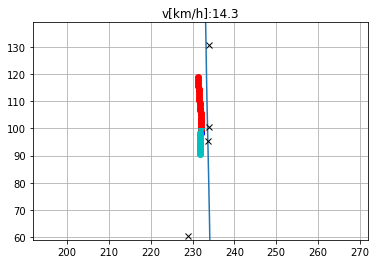

destroying actors.
done.


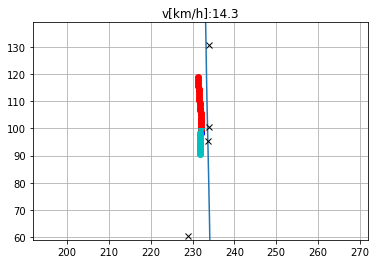

In [36]:
for fileName in drivesFileNames:
    main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)


In [25]:
# for fileName in drivesFileNames:
#     main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)
